# Source Finders in opticam_new

`opticam_new` uses `photutils` to find sources in images. Specifically, it uses image segmentation to detect and deblend sources. This notebook will demonstrate how to define source finders for use with `opticam_new`, as well as explain `opticam_new`'s default behaviour when no source finder is specified.

## Custom Source Finders

### Defining the Source Finder

First, let's define a source finder object:

In [2]:
from photutils.segmentation import detect_sources

from opticam_new.helpers import get_data

class Finder:
    
    def __init__(self, npixels, border_width):
        self.npixels = npixels
        self.border_width = border_width
    
    def __call__(self, image, threshold):
        
        if isinstance(image, str):
            data = get_data(image)
        else:
            data = image
        
        segment_map = detect_sources(data, threshold, self.npixels)  # identify sources
        segment_map.remove_border_labels(border_width=self.border_width, relabel=True)  # remove sources near the border
        
        return segment_map

In this example, I have defined the source finder to take two parameters:
- `npixels`: the number of connected pixels required to constitute a source (this value will depend on the image binning, but it should be more than one to avoid misidentifying hot pixels as sources).
- `border_width`: how far a source needs to be from the edge of the image to be identified.

In addition to the above parameters, when an instance of this source finder is called, it takes `image` and `threshold` parameters. The `image` parameter can either be the directory path to the image (e.g., `/home/user/Documents/Data/image.fits`) or it can be the image itself as a NumPy array. Note: custom source finders **must** take `image` and `threshold` inputs and return a `photutils.segmentation.SegmentationImage` object when they are called.

Now let's ise this source finder to identify sources in an image.

### Identifying Sources

For this example, we'll be using a test image generated by the `create_test_data.py` script. Let's open this image:

In [3]:
from astropy.io import fits
import numpy as np

with fits.open("/mnt/SATA1/Data/Opticam/Raw/Test/20240101/g-band_image_0.fits") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
FILTER  = 'g       '                                                            
BINNING = '8x8     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:00'                                                 


Let's plot the image to see what it looks like:

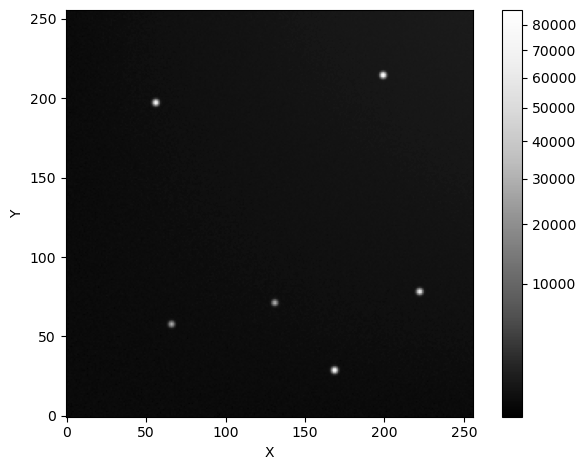

In [4]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

norm = simple_norm(image, stretch="sqrt")

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=norm, origin="lower", cmap="Greys_r")

fig.colorbar(im)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

Clearly, there are six sources in this image. Let's first subtract the background from this image, and then see if we can correctly identify all six sources:

In [5]:
from opticam_new import Background

background = Background(8)
finder = Finder(npixels=12, border_width=8)

bkg = background(image)
data_clean = image - bkg.background

segment_map = finder(data_clean, threshold=5*bkg.background_rms)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (256, 256)
nlabels: 6
labels: [1 2 3 4 5 6]


We have successfully identified the expected number of sources, but let's check they're been identified correctly:

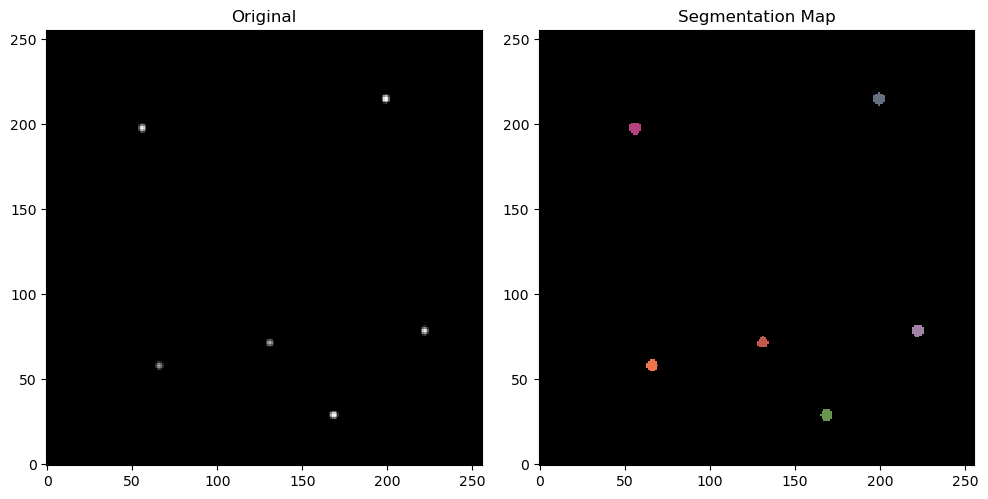

In [6]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

axs[0].set_title("Original")
axs[0].imshow(data_clean, norm=norm, origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Segmentation Map")
axs[1].imshow(segment_map, origin="lower", cmap=segment_map.cmap, interpolation="nearest")

plt.show()

As we can see, all sources have been correctly identified.

## The Default Source Finder

When using `opticam_new.Reducer()` to reduce data, a default source finder will be assumed if one is not provided. This default source finder (`opticam_new.Finder`) is similar to the source finder we defined above. When this source finder is initialised, `opticam_new` will assume default values for `npixels` and `border_width` depending on the image binning:
- 8x8 binning: `npixels=12`, `border_width=8`.
- 4x4 binning: `npixels=25`, `border_width=16`.
- 2x2 binning: `npixels=50`, `border_width=32`.
- 1x1 binning: `npixels=100`, `border_width=64`.
These default values are usually pretty good, but may need to be adjusted. In addition, `opticam_new`'s default source finder also implements deblending, useful for distinguishing sources in crowded fields. This uses the `photutils` defaults for `photutils.segmentation.deblend_sources()`.

For transparency, I will reproduce the default source finder below:

In [8]:
from photutils.segmentation import SourceFinder

class ReproducedDefaultFinder:
    
    def __init__(self, npixels: int = None, connectivity = 8, nlevels = 32, contrast = 0.001, mode = 'exponential',
                 border_width = 0):
        
        self.npixels = npixels
        self.connectivity = connectivity
        self.nlevels = nlevels
        self.contrast = contrast
        self.mode = mode
        self.border_width = border_width
        
        self.finder = SourceFinder(npixels=self.npixels, connectivity=self.connectivity, nlevels=self.nlevels,
                                   contrast=self.contrast, mode=self.mode, progress_bar=False)
    
    def __call__(self, image, threshold):
        
        if isinstance(image, str):
            data = get_data(image)
        else:
            data = image
        
        segment_map = self.finder(data, threshold)
        segment_map.remove_border_labels(border_width=self.border_width, relabel=True)
        
        return segment_map

    def get_input_dict(self):
        """
        While not necessary, it's good practise to include a method that returns the input parameters of the class as a
        dictionary. This is useful for logging and debugging purposes, as well as ensuring reproducible results in the
        future. If this method is provided, then when the class is instantiated in opticam_new.Reducer, the input
        parameters will be logged to `out_directory/misc/finder_input.json.
        """
        
        params_dict = {
            'npixels': self.npixels,
            'connectivity': self.connectivity,
            'nlevels': self.nlevels,
            'contrast': self.contrast,
            'mode': self.mode,
            'border_width': self.border_width
        }
        
        return params_dict

Let's now use the default source finder to identify the sources in the above image:

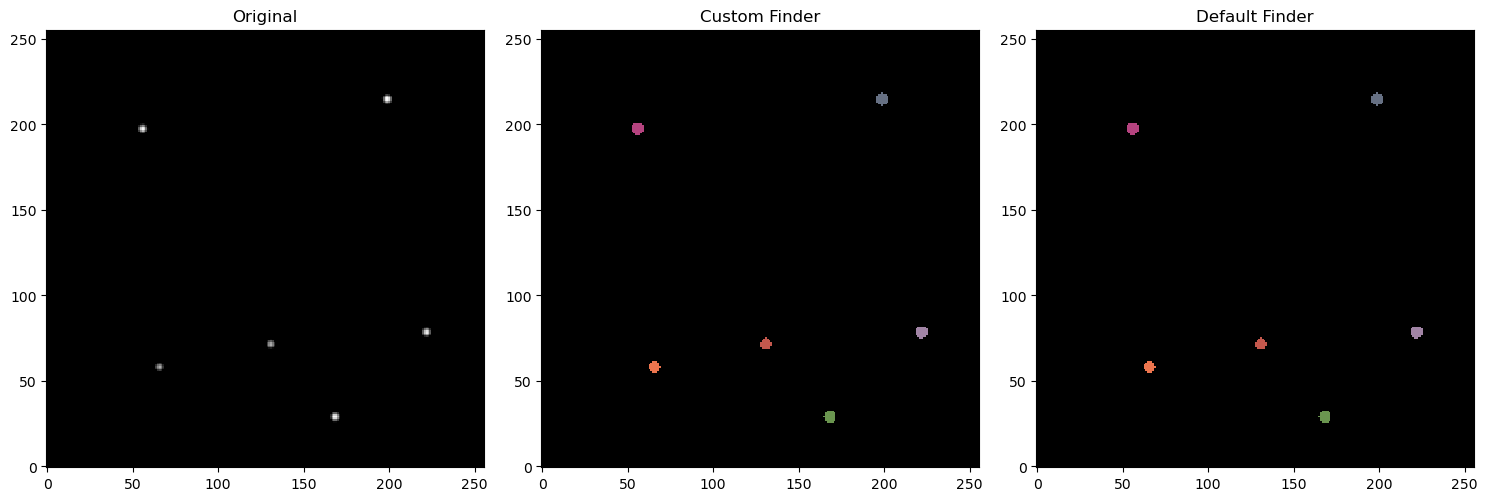

In [9]:
from opticam_new import Finder as DefaultFinder

default_finder = DefaultFinder(npixels=12, border_width=8)
default_segment_map = default_finder(data_clean, threshold=5*bkg.background_rms)

fig, axs = plt.subplots(ncols=3, tight_layout=True, figsize=(15, 5))

axs[0].set_title("Original")
axs[0].imshow(data_clean, norm=norm, origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Custom Finder")
axs[1].imshow(segment_map, origin="lower", cmap=segment_map.cmap, interpolation="nearest")

axs[2].set_title("Default Finder")
axs[2].imshow(default_segment_map, origin="lower", cmap=default_segment_map.cmap, interpolation="nearest")

plt.show()

As we can see, both methods correctly identify all six sources.

And that's it! Hopefully, `opticam_new` makes identifying sources in OPTICam images nice and easy! `photutils` does a lot of the heavy lifting here, so consider consulting their excellent documentation for more information about image segmentation and the features available.